In [24]:
%matplotlib inline

import os
from glob import glob
from collections import defaultdict

import yaml
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn
import pandas as pd
import networkx
import dinopy

from phasm.io import gfa
from phasm.io.sequences import FastaSource
from phasm.assembly_graph import AssemblyGraph
from phasm.bubbles import find_superbubbles, superbubble_nodes

BASE_DIR = os.path.realpath(os.path.join(os.getcwd(), '..'))

with open(os.path.join(BASE_DIR, "config.yml")) as f:
    config = yaml.load(f)
    
seaborn.set_style('whitegrid')

## Bubble chains cover the majority of the assembly graph

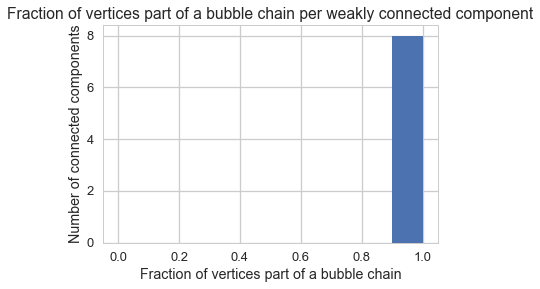

In [25]:
bubblechain_cover = []
for assembly in config['assemblies'].keys():
    parts = assembly.split('-')
    ploidy = int(parts[0].replace("ploidy", ""))
    coverage = int(parts[1].replace("x", ""))
    
    asm_folder = os.path.join(BASE_DIR, "assemblies", assembly)
    
    if coverage != 60:
        continue
    
    components = glob("{}/03_chain/component[0-9].graphml".format(asm_folder))
    
    for component in components:
        g = networkx.read_graphml(component)
        
        num_bubblechain_vert = 0
        for n in g.nodes_iter():
            if 'bubblechain' in g.node[n]:
                num_bubblechain_vert += 1
        
        bubblechain_cover.append(num_bubblechain_vert / g.number_of_nodes())
    
plt.figure()
plt.title('Fraction of vertices part of a bubble chain per weakly connected component')
plt.ylabel('Number of connected components')
plt.xlabel('Fraction of vertices part of a bubble chain')
plt.hist(bubblechain_cover, bins=10, range=(0.0, 1.0))
plt.savefig(os.path.join(BASE_DIR, 'figures', 'bubblechain-vertices.png'), dpi=256, transparent=True)

## Paths through bubble chains cover larger variants

1457
256643
49740.0078864
41063.0
76


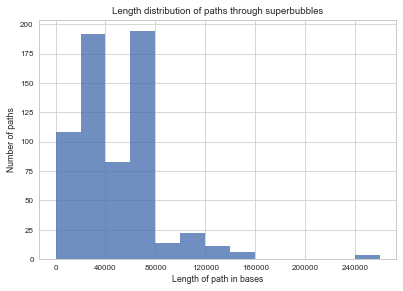

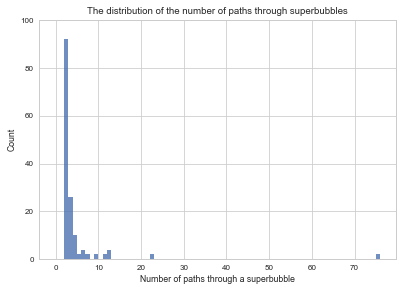

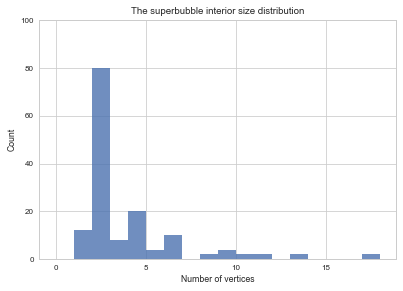

In [34]:
path_data = []
bubble_data = []
for assembly in config['assemblies'].keys():
    parts = assembly.split('-')
    ploidy = int(parts[0].replace("ploidy", ""))
    coverage = int(parts[1].replace("x", ""))
    
    asm_folder = os.path.join(BASE_DIR, "assemblies", assembly)
    
    if coverage != 60:
        continue
    
    bubblechains = glob("{}/03_chain/component[0-9].bubblechain[0-9].graphml".format(asm_folder))
    for bubblechain in bubblechains:
        g = AssemblyGraph(networkx.read_graphml(bubblechain))
        
        for (entrance, exit) in find_superbubbles(g, report_nested=False):
            num_paths  = 0
            total_path_length = 0
            for path in networkx.all_simple_paths(g, entrance, exit):
                path_len = g.path_length(
                    g.node_path_edges(path, data=True), include_last=False)
                path_data.append({
                    'ploidy': ploidy,
                    'coverage': coverage,
                    'path_length': path_len
                })
            
                num_paths += 1
                total_path_length = path_len
            
            interior = superbubble_nodes(g, entrance, exit) - {entrance, exit}
            bubble_data.append({
                'num_paths': num_paths,
                'interior_size': len(interior),
                'average_path_len': total_path_length / num_paths
            })
            
path_df = pd.DataFrame(path_data)
bubble_df = pd.DataFrame(bubble_data)

with seaborn.plotting_context("paper"):
    plt.figure()
    plt.title('Length distribution of paths through superbubbles')
    bin_size = 20000
    bins = list(range(0, path_df['path_length'].max() + bin_size, bin_size))
    seaborn.distplot(path_df['path_length'], bins=bins, kde=False, hist_kws={"alpha": 0.8})
    plt.ylabel('Number of paths')
    plt.xlabel('Length of path in bases')
    plt.gca().xaxis.set_major_locator(MultipleLocator(40000))
    plt.savefig(os.path.join(BASE_DIR, 'figures', 'path-length-dist.png'), dpi=256, transparent=True)

print(path_df['path_length'].min())
print(path_df['path_length'].max())
print(path_df['path_length'].mean())
print(path_df['path_length'].median())

plt.figure()
plt.title('The distribution of the number of paths through superbubbles')
bin_size = 1
bins = list(range(0, bubble_df['num_paths'].max()+bin_size, bin_size))
seaborn.distplot(bubble_df['num_paths'], kde=False, bins=bins, hist_kws={"alpha": 0.8})
plt.ylabel('Count')
plt.xlabel('Number of paths through a superbubble')
plt.ylim(ymax=100)
plt.savefig(os.path.join(BASE_DIR, 'figures', 'num-path-dist.png'), dpi=256, transparent=True)

print(bubble_df['num_paths'].max())

plt.figure()
plt.title('The superbubble interior size distribution')
bin_size = 1
bins = list(range(0, bubble_df['interior_size'].max()+bin_size, bin_size))
seaborn.distplot(bubble_df['interior_size'], kde=False, bins=bins, hist_kws={"alpha": 0.8})
plt.ylabel('Count')
plt.xlabel('Number of vertices')
plt.ylim(ymax=100)
plt.gca().xaxis.set_major_locator(MultipleLocator(5))
plt.savefig(os.path.join(BASE_DIR, 'figures', 'interior-size-dist.png'), dpi=256, transparent=True)

In [11]:
for assembly, asm_config in config['assemblies'].items():
    parts = assembly.split('-')
    ploidy = int(parts[0].replace("ploidy", ""))
    coverage = int(parts[1].replace("x", ""))
    
    if coverage != 60:
        continue
        
    asm_folder = os.path.join(BASE_DIR, "assemblies", assembly)
    alignments_gfa = os.path.join(asm_folder, "01_overlap", "alignments.gfa")
    with open(alignments_gfa) as f:
        reads = gfa.gfa2_parse_segments(f)
        
    read_source = FastaSource(os.path.join(asm_folder, "00_reads", "ploidy{}-{}x.fasta".format(ploidy, coverage)))
    
    reference_seqs = {}
    fr = dinopy.FastaReader(os.path.join(BASE_DIR, asm_config['reference']))
    for entry in fr.entries():
        name = entry.name.decode('utf-8').split()[0]
        reference_seqs[name] = entry.sequence.decode('utf-8').upper()
    
    bubblechains = glob("{}/03_chain/component[0-9].bubblechain[0-9].gfa".format(asm_folder))
    for bubblechain in bubblechains:
        print(bubblechain)
        with open(bubblechain) as f:
            graph_reads = gfa.gfa2_parse_segments_with_fragments(f)

        with open(bubblechain) as f:
            g = gfa.gfa2_reconstruct_assembly_graph(f, graph_reads, reads)

        g.sequence_src = read_source
        path_to_ref = {}
    
        for (entrance, exit) in find_superbubbles(g, report_nested=False):
            print("Bubble", entrance, exit)
            refs_included = set()
            for path in networkx.all_simple_paths(g, entrance, exit):
                path = tuple(path)
                path_seq = g.sequence_for_path(
                    g.node_path_edges(path, data=True), include_last=False).decode('utf-8')
                
                path_to_ref[path] = set()
                for ref, ref_seq in reference_seqs.items():
                    # print(type(ref_seq), len(ref_seq), type(path_seq), len(path_seq))
                    rev_comp = dinopy.reverse_complement(path_seq)
                    if path_seq in ref_seq or rev_comp in ref_seq:
                        path_to_ref[path].add(ref)
                        refs_included.add(ref)
                        
                if path_to_ref[path]:
                    print(path, path_to_ref[path])
                


/run/media/lucas/data/bioinformatics/thesis-data/assemblies/ploidy2-60x-error-free/03_chain/component1.bubblechain0.gfa
Bubble read4320+ merged160+
(OrientedRead[id=read4320+, len=19696], MergedReads[id=merged134, r0=read8393-...r7=read4009+, length=35082], MergedReads[id=merged160, r0=read7019-...r9=read2919-, length=21593]) {'BK006947.3.copy0'}
Bubble read7222- read4320+
(OrientedRead[id=read7222-, len=19164], MergedReads[id=merged181, r0=read8039+...r1=read8667+, length=21862], OrientedRead[id=read1656-, len=17428], MergedReads[id=merged6, r0=read6308-...r4=read7324-, length=32107], MergedReads[id=merged77, r0=read963-...r2=read6778-, length=15265], OrientedRead[id=read4320+, len=19696]) {'BK006947.3.copy0'}
Bubble merged32+ read7222-
Bubble merged58+ merged32+
Bubble merged131+ merged58+
Bubble merged106+ merged131+
Bubble merged108+ merged106+
Bubble read9802+ merged108+
(OrientedRead[id=read9802+, len=20742], MergedReads[id=merged81, r0=read1828-...r10=read126-, length=36409], Me

Bubble merged100+ merged62+
Bubble merged80+ merged100+
Bubble merged86+ merged80+
Bubble merged43+ merged86+
Bubble merged90+ merged43+
Bubble merged101+ merged90+
Bubble merged41+ merged101+
Bubble read7288- merged41+
(OrientedRead[id=read7288-, len=14359], OrientedRead[id=read3471+, len=15571], MergedReads[id=merged41, r0=read13524-...r9=read8672+, length=22611]) {'BK006947.3.copy1'}
Bubble read3522+ read7288-
(OrientedRead[id=read3522+, len=18497], MergedReads[id=merged124, r0=read14561-...r1=read7057-, length=17497], OrientedRead[id=read7288-, len=14359]) {'BK006947.3.copy1'}
Bubble merged30+ read3522+
Bubble merged67+ merged30+
Bubble merged104+ merged67+
Bubble merged59+ merged104+
Bubble merged78+ merged59+
Bubble read1875- merged78+
(OrientedRead[id=read1875-, len=20378], MergedReads[id=merged34, r0=read4462+...r2=read8199+, length=23582], MergedReads[id=merged78, r0=read9815-...r22=read9203-, length=78644]) {'BK006947.3.copy2'}
Bubble merged12+ read1875-
Bubble merged2+ merge

FileNotFoundError: [Errno 2] No such file or directory: '/run/media/lucas/data/bioinformatics/thesis-data/assemblies/ploidy8-60x-error-free/01_overlap/alignments.gfa'